# Assignment 1.3: NARMA10 task with RNN
This task consists of predicting the output of a 10th order non-linear autoregressive moving average (NARMA) system.
Given the input value x(t), the task is to predict the corresponding value of y(t).
* Import the dataset from the .csv file “NARMA10.csv” (available on the Moodle platform), where the first row represents the input, and the second row represents the target output. Different columns represent different time-steps.
* Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
* For the sake of problem understanding, you can try to first visualize the time-series data (using the matplotlib library in Python or the plot command in Matlab)

Remember: when training an RNN, you want to make sure to keep the last hidden state of your RNN after the training session, and use it as initial hidden state of the validation session. The same applies when transitioning to the test session.

1) Create and train a Time Delay Neural Network (TDNN) to solve the task, considering the fundamental hyperparameters (e.g., length of the input delay, training function/optimizer, learning rate, number of training epochs, etc.).

2) Perform a model selection (e.g., by grid search or random search) on the values of the hyperparameters identified in the previous point. Select on the validation set the best hyper-parametrization, as the one with the smallest Mean Squared Error (MSE).

3) Train the TDNN model with the selected hyper-parametrization on the whole training set, and evaluate its MSE on the training set and on the test set.

4) Repeat steps (1)-(3) also for Recurrent Neural Network (RNN), considering in this case the appropriate hyperparameters (e.g., in this case you don’t have an input delay line)

# Bonus-track Assignment 1.4: Mackey-Glass 17 task with RNN

The data for this task is available in the file “MG17.csv” (available on the Moodle platform), and it consists of one single row containing the values of the Q(t) time-series for all the time-steps in the different columns. The task consists in predicting 1 step in the future the Mackey-Glass dynamical system, i.e. predicting the value Q(t+1), just looking at Q(t) (or at a tapped delay line of order s, i.e. Q(t),...,Q(t-s), for a TDNN). Before splitting the data into training, validation and test splits, you need to organize it into input and target information. Specifically, the input should consist of the time-series values from the first time-step to the second-to-last, and the target in the time-series value from the second time-step to the last.

## Libraries

In [23]:
import pandas as pd
import copy
import sys
import torch
import json

from tqdm import tqdm
from itertools import product
from typing import Tuple

import numpy as np
from numpy import ndarray, expand_dims, hstack, zeros

from torch import Tensor, no_grad, zeros, from_numpy, cuda
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam

# To work with Google colab
!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Utils/utils.py
!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_1/Assignment1/models.py

from Utils.utils import show_loss, show_result
from LAB3_1.Assignment1.models import RecurrentNN

In [24]:
device = 'cuda' if cuda.is_available() else 'cpu'

## Trainer and Grid-search function

In [25]:
class RNN_trainer:
    def __init__(self, hidden:int, layers:int, no_linearity:str):

        # model
        self.model = RecurrentNN(hidden=hidden, layers=layers, no_linearity=no_linearity).to(device)

    def fit(self, df:ndarray, epochs:int=2, lr:float=0.001)->Tensor:
        """
        Give the raw dataset dt, the number of epochs and the learning rate.
        It fits the model and returns the training loss history.
        """

        df = from_numpy(df).float().contiguous().to(device)

        opt = Adam(self.model.parameters(), lr)
        history_tr = zeros(epochs) # Keep track the behavior of loss

        self.model.train()
        for i in range(epochs):

            opt.zero_grad(set_to_none=True)
            loss, _ = self.model(df[0], df[1])
            loss.backward()
            clip_grad_norm_(self.model.parameters(), 1)
            opt.step()

            # save the current loss
            history_tr[i] = loss.item()

        return history_tr  # return the history of loss

    def validate(self, df:ndarray, save_state:bool=False) -> Tuple:
        """
        Given a validation dataset, it performs the loss
        """
        df = from_numpy(df).float().contiguous().to(device)
        return  self.predict(df[0], df[1], save_state) + (df[1],)

    def predict(self, x:Tensor, y:Tensor=None, save_state:bool=False):
        """
        Predict the output of a certain input, if the target it is provided, the method performs also the loss,
        otherwise return only the output of the network.
        """

        self.model.eval()
        with no_grad():
            return  self.model(x, y, save_state)

In [26]:
class GridSearch:

    def __init__(self, parameters_grid:dict, tr:ndarray, dev:ndarray):

        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))

        """
        Returns the performance in each configuration:

            rank = a list of results for each configuration
            best = best model used to final retrain
            loss = training loss history of the best model
        """
        rank, best, loss = self.run(tr, dev, all_configs)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best
        self.tr_loss = loss

    @staticmethod
    def run(tr:ndarray, dev:ndarray, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # the keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss during the epochs
        best, loss = None, None
        best_dev_loss = sys.maxsize

        for config in tqdm(configs):  # try each configuration

            trainer = RNN_trainer(hidden=config["units"],
                                  layers=config["layers"],
                                  no_linearity=config["activ"])

            history = trainer.fit(tr, config["epochs"], config["lr"])
            vl_loss = trainer.validate(dev)[0].item()

            rank.append((config, round(history[-1].item(), 6), round(vl_loss, 6)))

            # we keep the best model
            if best_dev_loss > vl_loss:
                best_dev_loss = vl_loss
                loss = copy.deepcopy(history)
                best = copy.deepcopy(trainer)

        return rank, best, loss

## Retrieve the dataset

In [27]:
source1 = pd.read_csv("../sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("../sources/MG17.csv", header=None).T.to_numpy()

## NARMA10

### Hold-out

In [28]:
source1 = expand_dims(source1.T, axis=-1)
tr_dataset, dev_dataset, ts_dataset = source1[:,:4000], source1[:,4000:5000], source1[:,5000:]

### Grid search

In [29]:
json_dictionary = {}

In [30]:
ranges_to_explore = {
    "units" : [100, 200, 500],
    "epochs" : [80, 100],
    "lr" : [0.003, 0.008, 0.01],
    "layers": [1, 2],
    "activ" : ["relu","tanh"]
}

gs = GridSearch(ranges_to_explore,tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

json_dictionary["best_config"] = best_config

Number of configurations to try:  72


100%|██████████| 72/72 [11:56<00:00,  9.95s/it]


The best solution in  ({'units': 200, 'epochs': 80, 'lr': 0.003, 'layers': 2, 'activ': 'tanh'}, 0.002308, 0.002099)


### Training loss

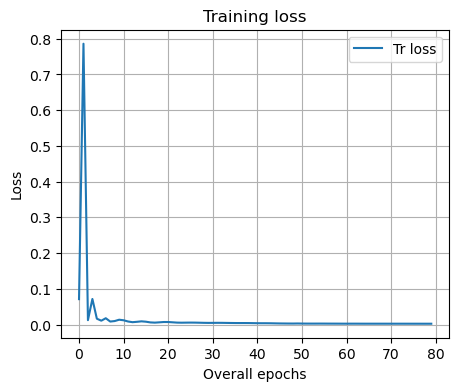

In [31]:
show_loss(gs.tr_loss)

### Train, Validation and Test errors in the best configuration

In [32]:
tr_loss = best_model.validate(tr_dataset, save_state=True)[0]
print("Train Error", round(tr_loss.item(), 6))

dev_loss = best_model.validate(dev_dataset)[0]
print("Validation Error", round(dev_loss.item(), 6))

test_loss = best_model.validate(ts_dataset)[0]
print("Test Error", round(test_loss.item(), 6))

json_dictionary["best_config"] = best_config
json_dictionary["Model_evaluation"] = (
    round(tr_loss.item(),6),
    round(dev_loss.item(),6),
    round(test_loss.item(),6))

Train Error 0.002294
Validation Error 0.002008
Test Error 0.001967


### Final retrain with Training and Validation set (with the best configuration)

In [33]:
final_trainer = RNN_trainer(hidden=best_config["units"],
                            layers=best_config["layers"],
                            no_linearity=best_config["activ"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = hstack([tr_dataset, dev_dataset])
tr_history = final_trainer.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_pred, tr_y = final_trainer.validate(final_tr)
print("Training Error", round(tr_loss.item(), 6))

test_loss, ts_pred, ts_y  = final_trainer.validate(ts_dataset)
print("Test Error", round(test_loss.item(), 6))

json_dictionary["Final_retrain"] = (
    round(tr_loss.item(),6),
    round(test_loss.item(),6))

Training Error 0.001976
Test Error 0.001759


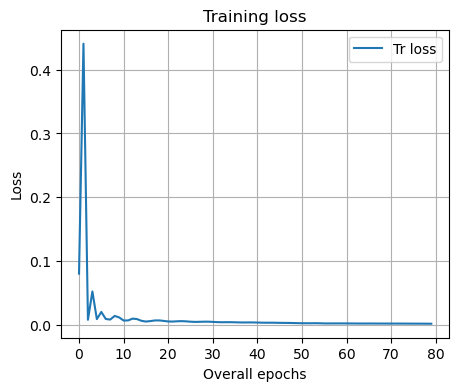

In [34]:
show_loss(tr_history)

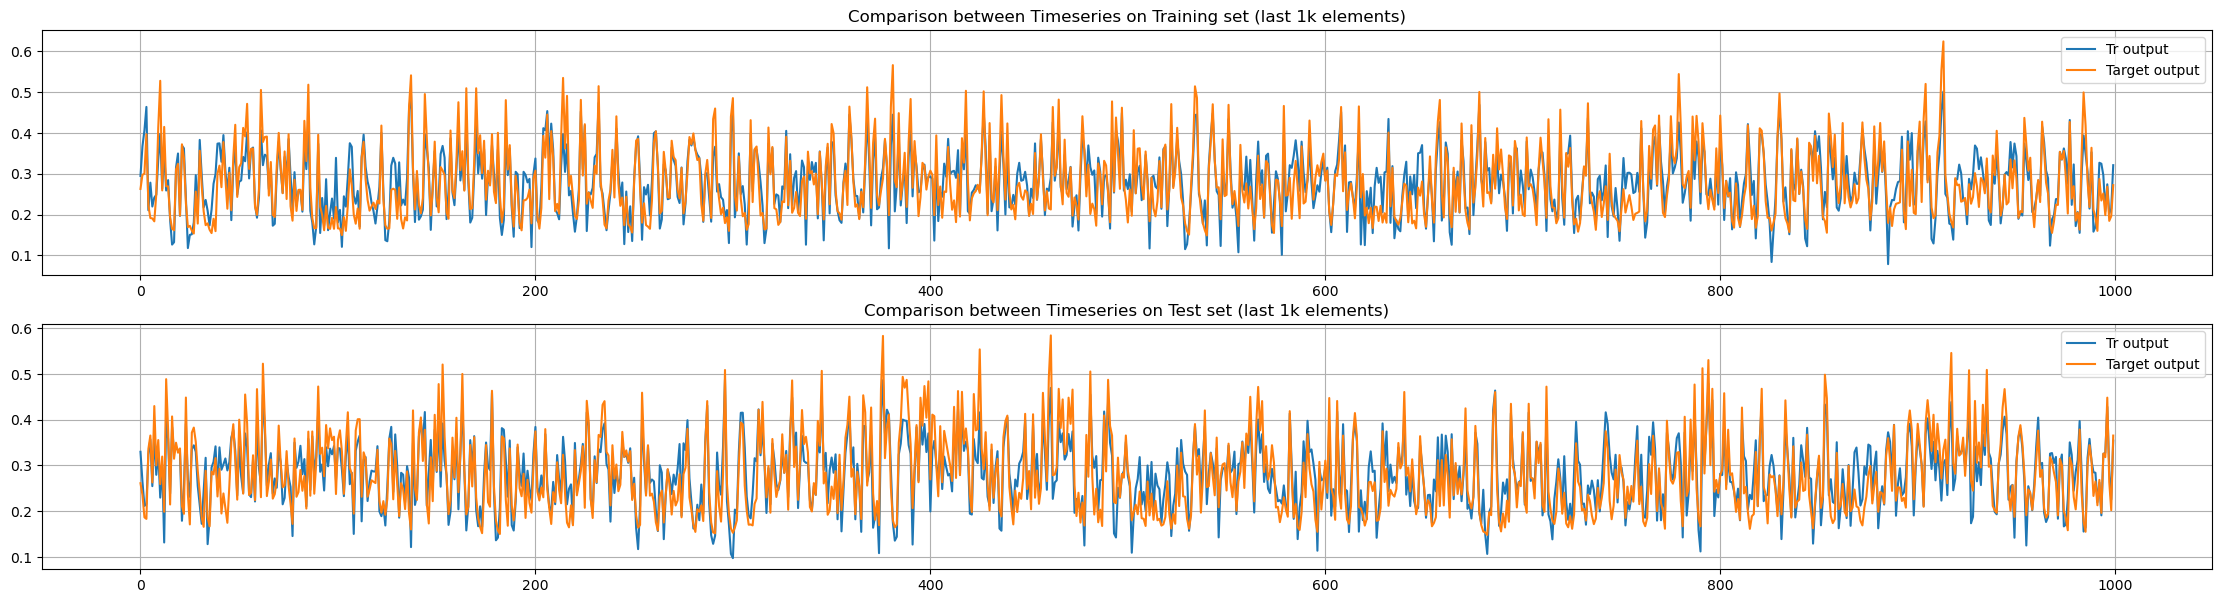

In [35]:
show_result(tr_pred, tr_y, ts_pred, ts_y)

In [36]:
torch.save([best_model.model,gs.tr_loss, tr_pred, tr_y, ts_pred, ts_y],"caches/RNN_narma10.pt")
with open("caches/metric_RNN_narma10.json", "w") as outfile:
    outfile.write(json.dumps(json_dictionary))

## Mackey-Glass 17

### Hold out

In [37]:
source_aligned = np.zeros((2, source2.shape[0]-1, 1))
source_aligned[0], source_aligned[1] = source2[:-1], source2[1:]
tr_dataset, dev_dataset, ts_dataset = source_aligned[:,:4000], source_aligned[:,4000:5000], source_aligned[:,5000:]

### Grid search

In [38]:
gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  72


100%|██████████| 72/72 [11:45<00:00,  9.80s/it]


The best solution in  ({'units': 500, 'epochs': 80, 'lr': 0.008, 'layers': 2, 'activ': 'relu'}, 2.7e-05, 6.1e-05)


### Training loss

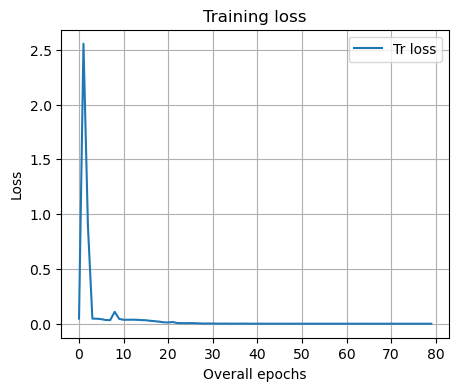

In [39]:
show_loss(gs.tr_loss)

## Train, Validation and Test errors in the best configuration

In [40]:
tr_loss = best_model.validate(tr_dataset, save_state=True)[0]
print("Train Error", round(tr_loss.item(), 6))

dev_loss = best_model.validate(dev_dataset)[0]
print("Validation Error", round(dev_loss.item(), 6))

test_loss = best_model.validate(ts_dataset)[0]
print("Test Error", round(test_loss.item(), 6))

json_dictionary["best_config"] = best_config
json_dictionary["Model_evaluation"] = (
    round(tr_loss.item(),6),
    round(dev_loss.item(),6),
    round(test_loss.item(),6))

Train Error 2.9e-05
Validation Error 1.8e-05
Test Error 6.8e-05


### Final retrain with Training and Validation set (with the best configuration)

In [41]:
final_trainer = RNN_trainer(hidden=best_config["units"],
                            layers=best_config["layers"],
                            no_linearity=best_config["activ"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = hstack([tr_dataset, dev_dataset])
tr_history = final_trainer.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_pred, tr_y = final_trainer.validate(final_tr)
print("Training Error", round(tr_loss.item(), 6))

test_loss, ts_pred, ts_y  = final_trainer.validate(ts_dataset)
print("Test Error", round(test_loss.item(), 6))

json_dictionary["Final_retrain"] = (
    round(tr_loss.item(),6),
    round(test_loss.item(),6))

Training Error 1.6e-05
Test Error 4.7e-05


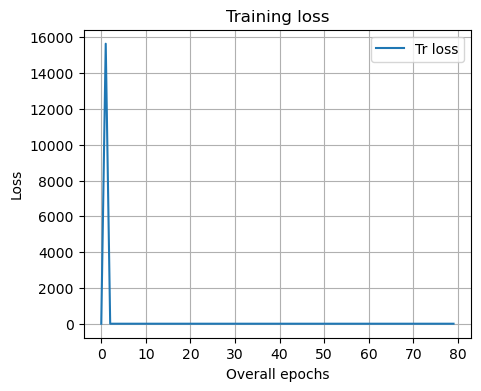

In [42]:
show_loss(tr_history)

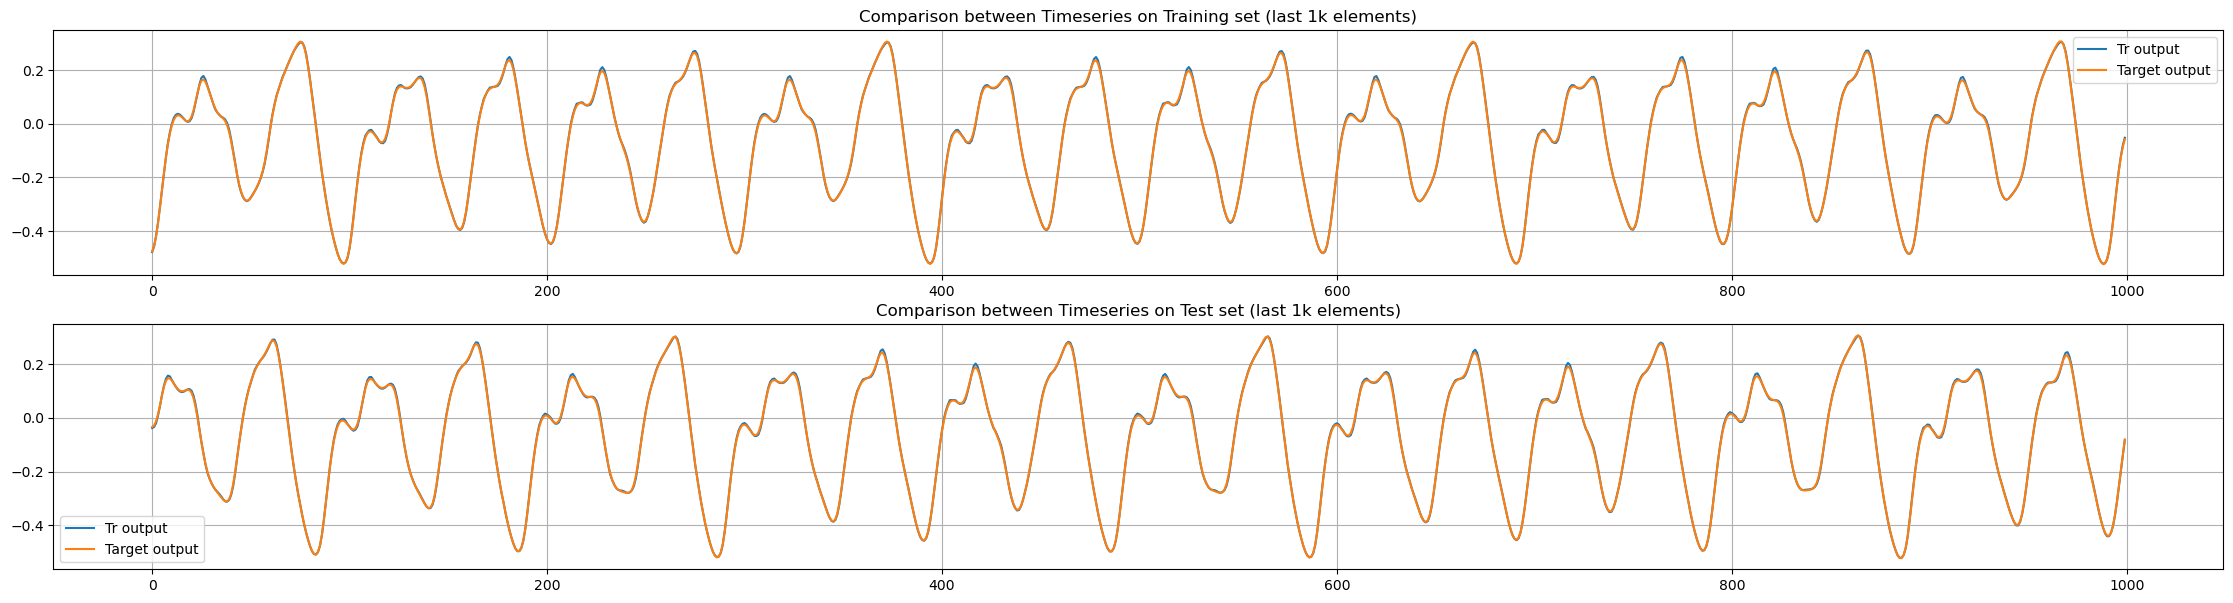

In [43]:
show_result(tr_pred, tr_y, ts_pred, ts_y)

In [44]:
torch.save([best_model.model,gs.tr_loss, tr_pred, tr_y, ts_pred, ts_y],"caches/RNN_mackey_glass17.pt")
with open("caches/metric_RNN_mackey_glass17.json", "w") as outfile:
    outfile.write(json.dumps(json_dictionary))